## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\devik\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\devik\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# reading the Treebank tagged sentences with universal tagset
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
#set the random seed
random.seed(1234)

#Splitting into training and test sets
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

#Get length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


In [7]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]

# Get length of total tagged words in training set
len(train_tagged_words)

95659

In [8]:
# tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'compromise',
 'sets',
 'the',
 'training',
 'wage',
 'at',
 '$',
 '3.35',
 '*U*']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12073


In [10]:
# number of pos tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'VERB', 'NOUN', 'PRT', 'ADV', 'ADJ', '.', 'CONJ', 'NUM', 'X', 'DET', 'PRON', 'ADP'}


As expected, there are 12 tags which are part of universal tagset.

### Lets build the Viterbi based POS tagger

In [11]:
# Create numpy array of no of pos tags by total vocabulary
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t (pos tags x pos tags)transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,VERB,NOUN,PRT,ADV,ADJ,.,CONJ,NUM,X,DET,PRON,ADP
VERB,0.168809,0.110965,0.031671,0.081617,0.065588,0.035543,0.005498,0.022689,0.217206,0.134428,0.035233,0.090754
NOUN,0.147366,0.264990,0.044013,0.016965,0.011504,0.239288,0.042448,0.009538,0.029379,0.012851,0.004514,0.177145
PRT,0.402403,0.247483,0.001949,0.009743,0.085093,0.043196,0.002273,0.055538,0.012991,0.100357,0.018188,0.020786
ADV,0.347913,0.032053,0.014023,0.077462,0.128214,0.136561,0.007012,0.031052,0.023038,0.069783,0.015693,0.117195
ADJ,0.012161,0.698932,0.010518,0.004766,0.067214,0.065078,0.017091,0.020707,0.021200,0.005094,0.000657,0.076582
.,0.087598,0.223671,0.002428,0.052253,0.045058,0.093084,0.057559,0.080763,0.027071,0.173307,0.066373,0.090746
CONJ,0.156177,0.350583,0.005128,0.056410,0.116084,0.035431,0.000000,0.039161,0.008392,0.122145,0.059207,0.051282
NUM,0.017365,0.351198,0.027246,0.002994,0.033533,0.116766,0.014371,0.184132,0.211078,0.003293,0.001497,0.036527
X,0.203948,0.061774,0.186276,0.024518,0.016876,0.163827,0.010508,0.002866,0.075147,0.054291,0.055883,0.144085
DET,0.040609,0.638627,0.000242,0.012569,0.205100,0.017525,0.000363,0.022117,0.044839,0.005560,0.003747,0.008702


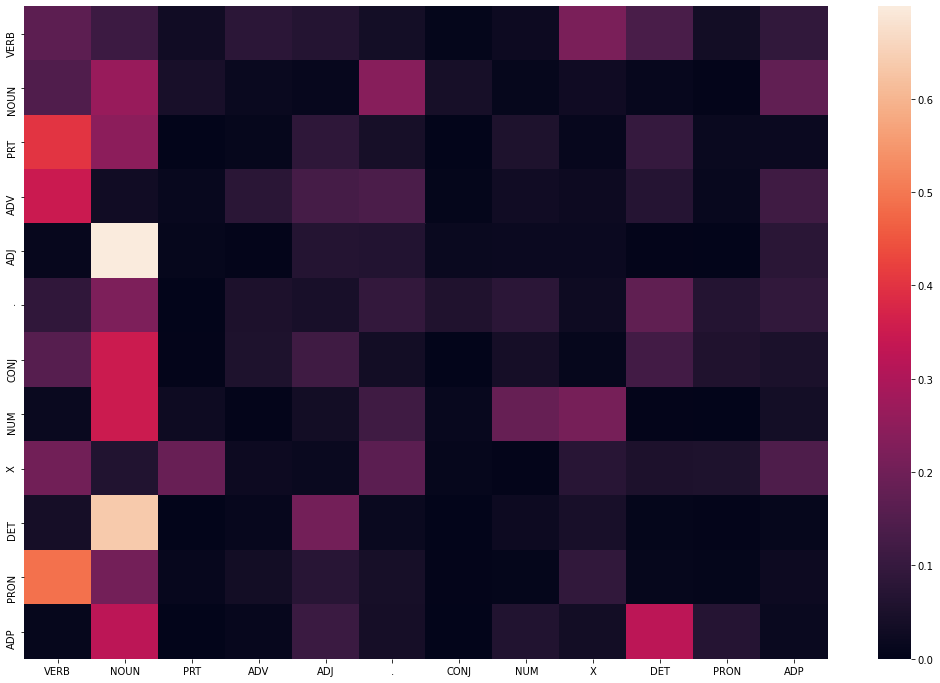

In [16]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

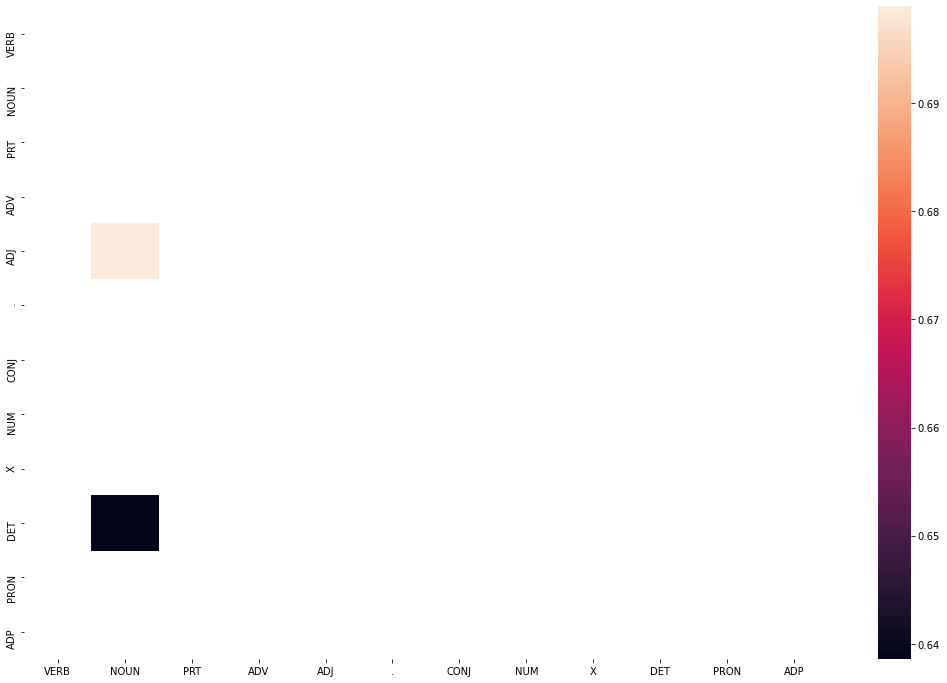

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

Clearly as expected Noun and Adjective and Noun and Determinent are highly correlated. 
Most often nouns are followed by adjectives and detectives

In [18]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of 10 sents on which we test the model
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
 
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [21]:
#Print total time taken to train the algorithm
print('Time taken: ', difference)

Time taken:  41.4293749332428


In [22]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Accuracy of the model: ', accuracy*100)

Accuracy of the model:  91.48936170212765


In [23]:
### We get around 89% of accuracy with the default Viterbi algorithm.

In [24]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('40.21', 'VERB'), ('40.21', 'NUM'))],
 [('or', 'CONJ'), (('16.09', 'VERB'), ('16.09', 'NUM'))],
 [('from', 'ADP'), (('28.36', 'VERB'), ('28.36', 'NUM'))],
 [('or', 'CONJ'), (('11.72', 'VERB'), ('11.72', 'NUM'))],
 [('High', 'NOUN'),
  (('test-preparation', 'VERB'), ('test-preparation', 'ADJ'))],
 [('years', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('a', 'DET'), (('scenic', 'VERB'), ('scenic', 'ADJ'))],
 [('a', 'DET'), (('planner', 'VERB'), ('planner', 'NOUN'))],
 [('the', 'DET'), (('morale-damaging', 'VERB'), ('morale-damaging', 'ADJ'))],
 [('Stephen', 'NOUN'), (('Akerfeldt', 'VERB'), ('Akerfeldt', 'NOUN'))],
 [('who', 'PRON'), (('*T*-128', 'VERB'), ('*T*-128', 'X'))],
 [('who', 'PRON'), (('*T*-129', 'VERB'), ('*T*-129', 'X'))],
 [('the', 'DET'),
  (('computer-generated', 'VERB'), ('computer-generated', 'ADJ'))],
 [('by', 'ADP'), (('certified', 'VERB'), ('certified', 'ADJ'))],
 [('certified', 'ADJ'), (('mail', 'VERB'), ('mail', 'NOUN'))],
 [('diaper', 'NOUN'), (

In [25]:
# We can see that most of the words which are not present in training set 
# are simply assigned the first pos tag in the training pos tagset

### Let's compare with the test sentences and see how it tagged the sentences

In [26]:
#Read the text file
lines=[]
f = codecs.open("Sample-test-sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Data Cleaning

In [27]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [28]:
# Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [29]:
nltk.download('punkt')

#Get the predictions on the test sentences
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Android', 'VERB'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'VERB'),
 ('.', '.'),
 ('Android', 'VERB'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'VERB'),
 ('OS', 'VERB'),
 ('worldwide', 'VERB'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'VERB'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'VERB'),
 ('.', '.'),
 ('Google', 'VERB'),
 ('and', 'CONJ'),
 ('Twitter', 'VERB'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'VERB'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'VERB'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'VERB'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'VERB'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'VERB'),


### Let us do the analysis on the test file 

### For words like 'Android','Google' the first tag in the training pos tagset is given.
### Let us see if these words exist in the training corpus

In [30]:
# Get tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [31]:
#Get list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['messages',
 'contested',
 'Satellite',
 'trips',
 'tournament',
 'tweets',
 'Android',
 'worldwide',
 'smartphones',
 '21st',
 'Google',
 'personality',
 'networking',
 'arriving',
 '2018',
 'Twitter',
 'FIFA',
 'ICESAT-2',
 'Cup',
 'NASA',
 'domineering',
 'OS',
 'interact',
 '2015',
 'best-selling',
 'online',
 '2013',
 'firehose',
 'invited',
 '2011']

Clearly the words like 'Google','Android','Fifa' are not present in the training set and they are all tagged default tags.

In [32]:
#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'VERB'),
 ('Google', 'VERB'),
 ('Android', 'VERB'),
 ('best-selling', 'VERB'),
 ('OS', 'VERB'),
 ('worldwide', 'VERB'),
 ('smartphones', 'VERB'),
 ('2011', 'VERB'),
 ('2013', 'VERB'),
 ('Google', 'VERB'),
 ('Twitter', 'VERB'),
 ('2015', 'VERB'),
 ('Google', 'VERB'),
 ('Twitter', 'VERB'),
 ('firehose', 'VERB'),
 ('Twitter', 'VERB'),
 ('online', 'VERB'),
 ('networking', 'VERB'),
 ('interact', 'VERB'),
 ('messages', 'VERB'),
 ('tweets', 'VERB'),
 ('domineering', 'VERB'),
 ('personality', 'VERB'),
 ('2018', 'VERB'),
 ('FIFA', 'VERB'),
 ('Cup', 'VERB'),
 ('21st', 'VERB'),
 ('FIFA', 'VERB'),
 ('Cup', 'VERB'),
 ('tournament', 'VERB'),
 ('contested', 'VERB'),
 ('Cup', 'VERB'),
 ('trips', 'VERB'),
 ('arriving', 'VERB'),
 ('NASA', 'VERB'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'VERB'),
 ('Satellite', 'VERB')]

In [33]:
from collections import Counter
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'VERB': 20, 'ADP': 3, 'NOUN': 1})

In [34]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20644262041195602


[('closed', 'VERB'),
 ('limited', 'VERB'),
 ('jumped', 'VERB'),
 ('sparked', 'VERB'),
 ('escalated', 'VERB'),
 ('triggered', 'VERB'),
 ('used', 'VERB'),
 ('resulted', 'VERB'),
 ('called', 'VERB'),
 ('placed', 'VERB'),
 ('earned', 'VERB'),
 ('posted', 'VERB'),
 ('compared', 'VERB'),
 ('expected', 'VERB'),
 ('divided', 'VERB'),
 ('dismissed', 'VERB'),
 ('crowded', 'VERB'),
 ('barred', 'VERB'),
 ('passed', 'VERB'),
 ('helped', 'VERB')]

Around 20% of words which end with 'ed' are verbs.

In [35]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10856434876877807


[('growing', 'VERB'),
 ('according', 'VERB'),
 ('leading', 'VERB'),
 ('buying', 'VERB'),
 ('being', 'VERB'),
 ('leaving', 'VERB'),
 ('looking', 'VERB'),
 ('recommending', 'VERB'),
 ('treating', 'VERB'),
 ('holding', 'VERB'),
 ('remaining', 'VERB'),
 ('Citing', 'VERB'),
 ('satisfying', 'VERB'),
 ('taking', 'VERB'),
 ('rising', 'VERB'),
 ('seeking', 'VERB'),
 ('being', 'VERB'),
 ('struggling', 'VERB'),
 ('according', 'VERB'),
 ('being', 'VERB')]

In [36]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6085
4253
0.6989317995069844


Around 70% of adjectives are followed by Nouns

In [37]:
#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8274
5284
0.6386270244138265


Around 63% of determinants are followed by Nouns

### Lets use the EDA done above and also grammar to build our rules for regex based tagger

In [38]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),                # gerund
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'.*es$', 'VERB'),                 # singular present verbs
    (r'.*ould$', 'VERB'),               # modal verbs
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                     # nouns
]

In [39]:
#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

### Let us use Brill algorithm as a base algorithm backed by the tagger created above

In [40]:
#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

### The state probabilities for unknown words become zero, hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

### Now lets modify the Viterbi algorithm such that when the state probabilities become zero it updates the tag based on the tagger we created above

In [41]:
#modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        
        if(pmax==0):
            state_max = brill_tagger.tag([word])[0][1] # assign tag based on the brill tagger
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]                
             
         
        state.append(state_max)
    return list(zip(words, state))

In [42]:
#test accuracy on subset of test data 
start = time.time()
tagged_seq = Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

In [43]:
print("Time taken: ", difference)

Time taken:  39.64696455001831


In [44]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
 
accuracy = len(check)/len(tagged_seq)
print('Accuracy of the model: ',accuracy*100)

Accuracy of the model:  95.0354609929078
